# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Chinese restaurant** in **Toronto**, Canada, the number of whom is increasing because of the fast growth of Chinese population in the city.

Since there are lots of restaurants in Toronto we will try to detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with no or few Chinese restaurants in vicinity**. We would also prefer locations **as close to city center (downtown Toronto) as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of and distance to Chinese restaurants in the neighborhood, if any
* distance of neighborhood from city center

We decided to use definition from [this wikipedia link](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* number of restaurants and their type, review and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Toronto neighborhood will be obtained using a csv file input

### Neighborhood in Toronto

We download the neighborhood table from the wikipedia page, the table contains all neighborhoods in Canada, therefore we extract the ones only from Toronto, and attach the coordinates of the neighborhoods using a csv file.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import urllib.request
import html5lib
import numpy as np
from bs4 import BeautifulSoup
import requests
from math import radians, sin, cos, acos, atan2, sqrt

p_can_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
fp = urllib.request.urlopen(p_can_url)
p_can_html = fp.read()
p_can_html = p_can_html.decode("utf8")
fp.close()
p_can = BeautifulSoup(p_can_html)

df_p_can = []
for tr in p_can.table.find_all('tr'):
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    df_p_can.append(row)
df_p_can=pd.DataFrame(df_p_can,columns=['Postcode','Borough','Neighborhood'])
df_p_can=df_p_can[df_p_can['Borough']!='Not assigned']
df_p_can=df_p_can[df_p_can.Borough.notnull()]
df_p_can['Neighborhood']=df_p_can['Neighborhood'].replace({'\n':''}, regex=True)

df_p_can['Neighborhood'] = np.where(df_p_can['Neighborhood'] == 'Not assigned', df_p_can['Borough'], df_p_can['Neighborhood'])
df_p_can=df_p_can.groupby(['Postcode','Borough'])['Neighborhood'].apply(','.join).reset_index()
coord = pd.read_csv('http://cocl.us/Geospatial_data')
df_coord_can=pd.merge(df_p_can, coord, left_on='Postcode', right_on='Postal Code').drop(['Postal Code'], axis=1)
df_t=df_coord_can[df_coord_can['Borough'].isin(['Downtown Toronto','East Toronto','West Toronto','Central Toronto'])]
dist = []

def cal_dist(lat1,lon1,lat2,lon2):
    lat1=radians(lat1)
    lat2=radians(lat2)
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1) 
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2 
    c = 2 * atan2( sqrt(a), sqrt(1-a) ) 
    d = 6371 * c
    return(d)

for lat, lon in zip(df_t['Latitude'], df_t['Longitude']):
    dist_c = cal_dist(lat,lon,43.645436,-79.380978)
    dist.append(dist_c)
df_t['Distance to Center'] = dist
df_t.reset_index(inplace = True, drop = True)
df_t.head(5)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance to Center
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,7.074931
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,2.316830
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,5.261988
3,M4M,East Toronto,Studio District,43.659526,-79.340923,3.222700
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0.648280


The data looks good, now we have all the neighborhoods in Toronto and their coordinates with the distance to Toronto city center. Let's visualize the neighborhoods in the map of Toronto.

In [2]:
#!pip install folium

import folium

map_t = folium.Map(location=[43.645436, -79.380978], zoom_start=12)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df_t['Latitude'], df_t['Longitude'], df_t['Borough'], df_t['Neighborhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_t)  
    
map_t

### Foursquare

Now that we have our neighborhoods data, we can use Foursquare API to get info on (Chinese) restaurants in each neighborhood.

From the API we will get a list of the restaurants, and their types, locations, reviews. And from the list we could feature the neighborhoods with the number of restaurants, the number of Chinese restaurants, average review of the restaurants, and along with their distance to the city center. Using the features, we can cluster the neighborhoods and identify the best (group of) neighborhoods for openning a Chinese restaurant.

In [3]:
CLIENT_ID = 'NDY0KYVXE2M1QNO1TEQZ3JOJZNG1031QQVXXYR1XX0LVHNO5'
CLIENT_SECRET = '3RQYFN53TWP4DJZXCGQAV1QNRHO2VEJQTFSEIYBFTBARWGZM'
VERSION = '20190401' # Foursquare API version

In [4]:
# Category IDs corresponding to Chinese restaurants were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues

chinese_restaurant_categories = ['4bf58dd8d48988d145941735','52af3a5e3cf9994f4e043bea','52af3a723cf9994f4e043bec',
                                 '52af3a7c3cf9994f4e043bed','58daa1558bbb0b01f18ec1d3','52af3a673cf9994f4e043beb',
                                 '52af3a903cf9994f4e043bee','4bf58dd8d48988d1f5931735','52af3a9f3cf9994f4e043bef',
                                 '52af3aaa3cf9994f4e043bf0','52af3ab53cf9994f4e043bf1','52af3abe3cf9994f4e043bf2',
                                 '52af3ac83cf9994f4e043bf3','52af3ad23cf9994f4e043bf4','52af3add3cf9994f4e043bf5',
                                 '52af3af23cf9994f4e043bf7','52af3ae63cf9994f4e043bf6','52af3afc3cf9994f4e043bf8',
                                 '52af3b053cf9994f4e043bf9','52af3b213cf9994f4e043bfa','52af3b293cf9994f4e043bfb',
                                 '52af3b343cf9994f4e043bfc','52af3b3b3cf9994f4e043bfd','52af3b463cf9994f4e043bfe',
                                 '52af3b633cf9994f4e043c01','52af3b513cf9994f4e043bff','52af3b593cf9994f4e043c00',
                                 '52af3b6e3cf9994f4e043c02','52af3b773cf9994f4e043c03','52af3b813cf9994f4e043c04',
                                 '52af3b893cf9994f4e043c05','52af3b913cf9994f4e043c06','52af3b9a3cf9994f4e043c07',
                                 '52af3ba23cf9994f4e043c08']

def is_chinese_restaurant(categories, specific_filter=None):
    specific = False
    for c in categories:
        category_id = c[1]
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
    return specific

def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, VERSION, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   item['venue']['location'],
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues


def get_restaurants(lats, lons, neighborhoods):
    restaurants = {}
    all_chinese_restaurants = {}
    location_restaurants = []
    location_chinese_restaurants = []

    print('Obtaining venues around candidate locations:', end='')
    for lat, lon, neighborhood in zip(lats, lons, neighborhoods):
        venues = get_venues_near_location(lat, lon, food_category, CLIENT_ID, CLIENT_SECRET, radius=600, limit=100)
        area_restaurants = []
        chinese_restaurants = []
        for venue in venues:
            venue_id = venue[0]
            venue_neighborhood = neighborhood
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_chinese = is_chinese_restaurant(venue_categories, specific_filter=chinese_restaurant_categories)
            restaurant = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_chinese)
            if venue_distance<=500:
                area_restaurants.append(restaurant)
            restaurants[venue_id] = restaurant
            if is_chinese:
                all_chinese_restaurants[venue_id] = restaurant
                chinese_restaurants.append(restaurant)
        location_restaurants.append(area_restaurants)
        location_chinese_restaurants.append(chinese_restaurants)
        print(' .', end='')
    print(' done.')
    return restaurants, all_chinese_restaurants, location_restaurants, location_chinese_restaurants

restaurants, all_chinese_restaurants, location_restaurants, location_chinese_restaurants = get_restaurants(df_t['Latitude'], df_t['Longitude'], df_t['Neighborhood'])


Obtaining venues around candidate locations: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


In [5]:
print('Total number of restaurants:', len(restaurants))
print('Total number of Chinese restaurants:', len(all_chinese_restaurants))
print('Percentage of Chinese restaurants: {:.2f}%'.format(len(all_chinese_restaurants) / len(restaurants) * 100))
print('Average number of restaurants in neighborhood:', np.array([len(r) for r in location_restaurants]).mean())

Total number of restaurants: 1168
Total number of Chinese restaurants: 34
Percentage of Chinese restaurants: 2.91%
Average number of restaurants in neighborhood: 31.07894736842105


There are only 2.82% Chinese restaurant in general, which already indicates a good opportunity. Let's now see all the collected restaurants in our area of interest on map, and let's also show Chinese restaurants in different color.

In [6]:
map_t = folium.Map(location=[43.645436, -79.380978], zoom_start=12)
folium.Marker([43.645436, -79.380978], popup='Toronto').add_to(map_t)
for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_chinese = res[6]
    color = 'red' if is_chinese else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_t)
map_t

## Methodology <a name="methodology"></a>

In this project we will try to identify neighborhoods in Toronto that have low restaurant density, especially those with low Chinese restaurant density. We use neighborhoods definition from the wikipedia page listed in the previous section.

We have already imported the data needed for the project from two sources: wikipedia page and foursquare API. The data contain the names and locations (coordinates) of the neighborhoods and the restaurants within them.

In the following parts, we will explore the restaurant density across neighborhoods in Toronto and deep dive into the ones with low restaurant density to find the most promising neighborhoods for openning a new Chinese restaurant for our stakeholders. We will use both a rule based method and k-means clustering to filter out the neighborhoods.

Finnally, we will summarize the analysis and present actionable conclusions for the stakeholders.

## Analysis <a name="analysis"></a>

Firstly, let's calculate the number of restaurants and Chinese restaurants, and the distance to the closest Chinese restaurants in each neighborhood and compare them to the average value of all neighborhoods.

In [7]:
location_restaurants_count = [len(res) for res in location_restaurants]
df_t['Restaurants in area'] = location_restaurants_count
print('Average number of restaurants in every area with radius=500m:', np.array(location_restaurants_count).mean())

Average number of restaurants in every area with radius=500m: 31.07894736842105


Text(0,0.5,'Neighborhoods')

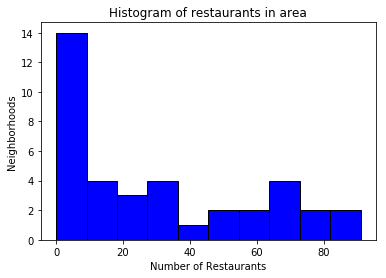

In [9]:
from matplotlib import pyplot as plt

plt.hist(df_t['Restaurants in area'], color = 'blue', edgecolor = 'black')
plt.title('Histogram of restaurants in area')
plt.xlabel('Number of Restaurants')
plt.ylabel('Neighborhoods')

Although on average there are 31 restaurants in each neighborhood, over 1/3 of the neighborhoods have less than 10 restaurants in the area, indicating opportunity for business there.

In [10]:
location_chinese_restaurants_count = [len(res) for res in location_chinese_restaurants]
df_t['Chinese restaurants in area'] = location_chinese_restaurants_count
print('Average number of Chinese restaurants in every area with radius=500m:', np.array(location_chinese_restaurants_count).mean())

Average number of Chinese restaurants in every area with radius=500m: 1.105263157894737


Text(0,0.5,'Neighborhoods')

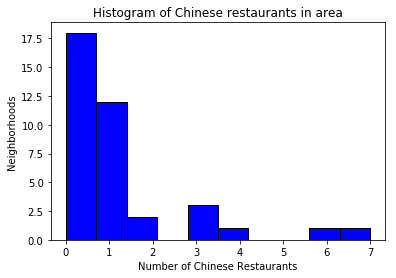

In [11]:
plt.hist(df_t['Chinese restaurants in area'], color = 'blue', edgecolor = 'black')
plt.title('Histogram of Chinese restaurants in area')
plt.xlabel('Number of Chinese Restaurants')
plt.ylabel('Neighborhoods')

Similarly, we find that most Chinese restaurants are conjesting in four neighborhoods, leaving the others with only a few selection. And nearly half of the neighborhoods do not have a Chinese restaurant yet.

In [12]:
distances_to_chinese_restaurant = []

for lat, lon in zip(df_t['Latitude'], df_t['Longitude']):
    min_distance = 10000
    for res in all_chinese_restaurants.values():
        lat_c = res[2]
        lon_c = res[3]
        dist = cal_dist(lat,lon,lat_c,lon_c)
        if dist<min_distance:
            min_distance = dist
    distances_to_chinese_restaurant.append(min_distance)

df_t['Distance to Chinese restaurant'] = distances_to_chinese_restaurant
print('Average distance to closest Chinese restaurant from each area center:', round(df_t['Distance to Chinese restaurant'].mean(),2), 'km')

Average distance to closest Chinese restaurant from each area center: 0.53 km


Text(0,0.5,'Neighborhoods')

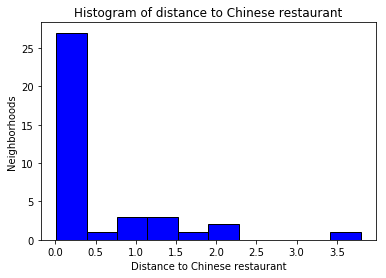

In [13]:
plt.hist(df_t['Distance to Chinese restaurant'], color = 'blue', edgecolor = 'black')
plt.title('Histogram of distance to Chinese restaurant')
plt.xlabel('Distance to Chinese restaurant')
plt.ylabel('Neighborhoods')

However, the distribution of the distance to the closest Chinese restaurant of each neighborhood shows that actually almost 2/3 neighborhoods have access to a Chinese restaurant within 500 meter to its center. This is because the neighborhoods in center Toronto are close to each other, so that the neighborhoods can easily access the Chinese restaurants in another neighborhood nearby.

In [14]:
df_t.head(10)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance to Center,Restaurants in area,Chinese restaurants in area,Distance to Chinese restaurant
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,7.074931,2,0,3.794722
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,2.316830,36,0,0.964104
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,5.261988,11,0,1.981819
3,M4M,East Toronto,Studio District,43.659526,-79.340923,3.222700,23,1,0.057546
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0.648280,1,1,0.104774
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,0.752838,5,0,0.106863
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,1.990953,8,1,0.166384
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,0.638590,33,1,0.091832
8,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160,0.195288,1,0,0.081521
9,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049,1.536078,8,2,0.064843


Recall that our criterion to find the optimal neighborhoods for openning a Chinese restaurant are distance to city center, number of restaurants, number of Chinese restaurants, and distance to the closest Chinese restaurant. Now let's create a bubble chart to visualize the four features on the same plot. 

Text(0.5,1,'Battle of the Neighborhood - Chinese restaurants')

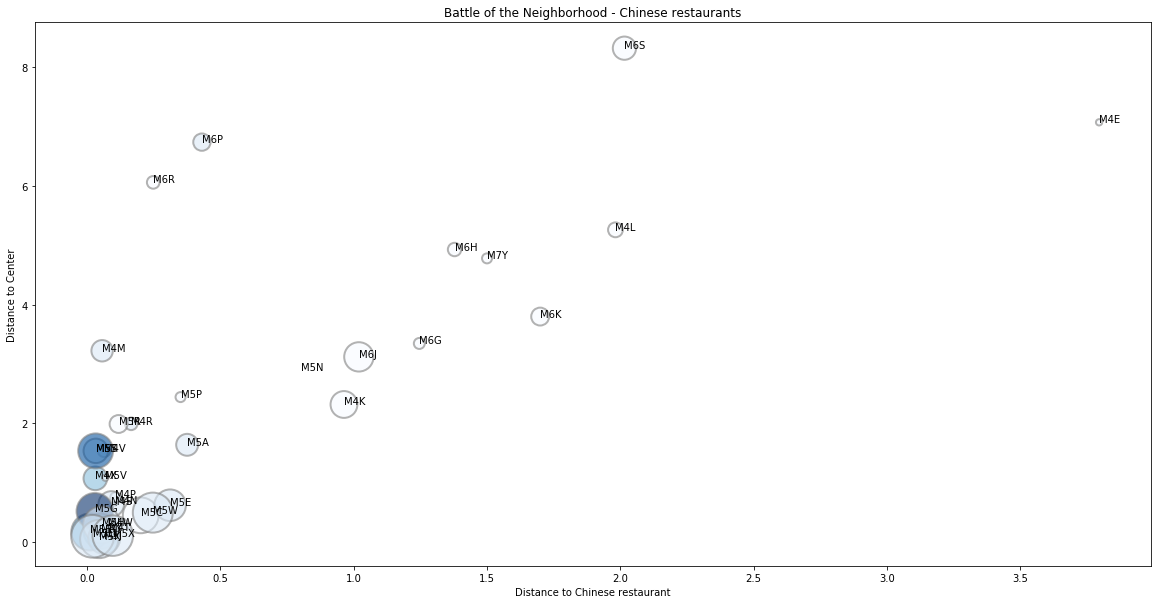

In [16]:
import seaborn as sns

#plt.figure(figsize=(20,10))
#plt.scatter(df_t['Distance to Chinese restaurant'], df_t['Distance to Center'], s=df_t['Restaurants in area']*20, c=df_t['Chinese restaurants in area']+1, label = df_t['Neighborhood'], cmap="Blues", alpha=0.6, edgecolors="grey", linewidth=2)

# Add titles (main and on axis)
#plt.xlabel("Distance to Chinese restaurant")
#plt.ylabel("Distance to Center")
#plt.title("Battle of the Neighborhood - Chinese restaurants")
 
#plt.show()

fig, ax = plt.subplots(figsize=(20,10))
sc = ax.scatter(df_t['Distance to Chinese restaurant'], df_t['Distance to Center'], s=df_t['Restaurants in area']*20, c=df_t['Chinese restaurants in area']+1,cmap="Blues", alpha=0.6, edgecolors="grey", linewidth=2)
for i, txt in enumerate(df_t.Postcode):
    ax.annotate(txt, (df_t['Distance to Chinese restaurant'].iat[i],df_t['Distance to Center'].iat[i]))
ax.set_xlabel("Distance to Chinese restaurant")
ax.set_ylabel("Distance to Center")
ax.set_title("Battle of the Neighborhood - Chinese restaurants")

In the chart, smaller size indicates less restaurants in the neighborhood and lighter color indicates less Chinese restaurants. From the chart, M5N and M6G are two obvious options with low number of both restaurants and Chinese restaurants, which are relatively close to city center, while not so close to a Chinese restaurant.

Let's use the average number we calculated above as a benchmark to filter the neighborhoods with relatively low number of restaurants and Chinese restaurants and far from a Chinese restaurant. And then we can sort the neighborhoods by the distance to Toronto city center, and use a heat map to highlight the features.

From the table below we could see that indeed M5N (Roselawn) and M6G (Christie) are on the top of the list, following by M7Y (Business Reply Mail Processing Centre 969 Eastern) and M6H (Dovercourt Village,Dufferin) which are a bit far from the city center, but with not too much competition. M6K (Brockton,Exhibition Place,Parkdale Village) has 16 restaurants, however, since it is closer to city center, and there are no Chinese restaurants in and around, it can also be a not bad option here. The other neighborhoods are too far from city center (M4L, M4E and M6S).

In [26]:
cm = sns.diverging_palette(240, 10, n=20, as_cmap =True)

(df_t[(df_t['Restaurants in area']<31)&(df_t['Chinese restaurants in area']<1.1)&(df_t['Distance to Chinese restaurant']>0.53)].sort_values(by=['Distance to Center']).style
     .background_gradient(cmap=cm, subset = ['Distance to Center'])
     .background_gradient(cmap=cm, subset = ['Chinese restaurants in area'])
     .background_gradient(cmap=cm, subset = ['Restaurants in area'])
     .background_gradient(cmap=cm, subset = ['Distance to Chinese restaurant']))

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance to Center,Restaurants in area,Chinese restaurants in area,Distance to Chinese restaurant
22,M5N,Central Toronto,Roselawn,43.7117,-79.4169,2.89453,0,0,0.801474
30,M6G,Downtown Toronto,Christie,43.6695,-79.4226,3.34578,6,0,1.24655
33,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.6368,-79.4282,3.79926,16,0,1.69952
37,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.6627,-79.3216,4.78056,5,0,1.50032
31,M6H,West Toronto,"Dovercourt Village,Dufferin",43.669,-79.4423,4.93015,9,0,1.37864
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.669,-79.3156,5.26199,11,0,1.98182
0,M4E,East Toronto,The Beaches,43.6764,-79.293,7.07493,2,0,3.79472
36,M6S,West Toronto,"Runnymede,Swansea",43.6516,-79.4844,8.32528,27,0,2.01543


Apart from the rule based analysis, we can also use Kmeans to cluster the neighborhoods using their distance to city center, number of restaurants, number of Chinese restaurants and distance to the closest Chinese restaurants as features, to group the neighborhoods with similar characteristics.

In [44]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

number_of_clusters = 15

df_t_features = df_t[['Distance to Center', 'Chinese restaurants in area', 'Restaurants in area', 'Distance to Chinese restaurant']].values
df_t_features = preprocessing.StandardScaler().fit(df_t_features).transform(df_t_features)
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(df_t_features)

We cluster the neighborhoods into 15 groups, the features are normalized in the model.

The following table gives the average distance to city center, number of restaurants, number of Chinese restaurants and distance to the closest Chinese restaurants as features of the groups.

Out of the groups, we find that group 13 and 4 have low number of restaurants and Chinese restaurants, and are far from a Chinese restaurant, however they are not so close to city center.

Apart from that, we can also find that group 12, which is very close to the city center, have very low number of restaurants and no Chinese restaurants. Although the neighborhoods can access to a Chinese restaurant easily (84 meter on average), we can still assume a good opportunity there.

In [45]:
df_t['label'] = kmeans.labels_
(df_t.groupby(['label']).mean().sort_values(by=['Distance to Center']).style
     .background_gradient(cmap=cm, subset = ['Distance to Center'])
     .background_gradient(cmap=cm, subset = ['Chinese restaurants in area'])
     .background_gradient(cmap=cm, subset = ['Restaurants in area'])
     .background_gradient(cmap=cm, subset = ['Distance to Chinese restaurant']))

,Latitude,Longitude,Distance to Center,Restaurants in area,Chinese restaurants in area,Distance to Chinese restaurant
label,,,,,,
3,43.6546,-79.3813,0.136224,60.3333,3.33333,0.0432346
5,43.6487,-79.3798,0.246114,76.5,0.833333,0.111956
12,43.6777,-79.3863,0.578883,2.25,0,0.0844835
1,43.6745,-79.381,0.627939,41.5,1,0.202063
6,43.6556,-79.3937,1.02519,64,6.5,0.0317196
11,43.7072,-79.3944,1.09218,4.5,1.5,0.0848081
9,43.6653,-79.3839,1.30288,29,2.5,0.0329502
2,43.6848,-79.4085,2.21456,10.5,0,0.235312
14,43.6764,-79.3691,2.28347,18.3333,1,0.200044


Let's see what are those neighborhoods. Firstly, let's list neighborhoods in group 4 and 13. We can see that they match the ones we identify in the rule based analysis.

In [46]:
(df_t[(df_t['label']==13)|(df_t['label']==4)].sort_values(by=['label']).style
     .background_gradient(cmap=cm, subset = ['Distance to Center'])
     .background_gradient(cmap=cm, subset = ['Chinese restaurants in area'])
     .background_gradient(cmap=cm, subset = ['Restaurants in area'])
     .background_gradient(cmap=cm, subset = ['Distance to Chinese restaurant']))

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance to Center,Restaurants in area,Chinese restaurants in area,Distance to Chinese restaurant,label
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.669,-79.3156,5.26199,11,0,1.98182,4
31,M6H,West Toronto,"Dovercourt Village,Dufferin",43.669,-79.4423,4.93015,9,0,1.37864,4
33,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",43.6368,-79.4282,3.79926,16,0,1.69952,4
37,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.6627,-79.3216,4.78056,5,0,1.50032,4
22,M5N,Central Toronto,Roselawn,43.7117,-79.4169,2.89453,0,0,0.801474,13
30,M6G,Downtown Toronto,Christie,43.6695,-79.4226,3.34578,6,0,1.24655,13


In group 12, M4T (Moore Park,Summerhill East) and M4W (Rosedale) have the biggest potential. They are almost located in the city center, and both have only one restaurants and no Chinese restaurants.

In [47]:
(df_t[(df_t['label']==12)].sort_values(by=['label']).style
     .background_gradient(cmap=cm, subset = ['Distance to Center'])
     .background_gradient(cmap=cm, subset = ['Chinese restaurants in area'])
     .background_gradient(cmap=cm, subset = ['Restaurants in area'])
     .background_gradient(cmap=cm, subset = ['Distance to Chinese restaurant']))

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance to Center,Restaurants in area,Chinese restaurants in area,Distance to Chinese restaurant,label
5,M4P,Central Toronto,Davisville North,43.7128,-79.3902,0.752838,5,0,0.106863,12
8,M4T,Central Toronto,"Moore Park,Summerhill East",43.6896,-79.3832,0.195288,1,0,0.0815214,12
10,M4W,Downtown Toronto,Rosedale,43.6796,-79.3775,0.285204,1,0,0.0800113,12
27,M5V,Downtown Toronto,"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",43.6289,-79.3944,1.0822,2,0,0.0695384,12


## Results and Discussion <a name="results"></a>

We have found M5N (Roselawn), M6G (Christie), M7Y (Business Reply Mail Processing Centre 969 Eastern), M6H (Dovercourt Village,Dufferin), M6K (Brockton,Exhibition Place,Parkdale Village), M4T (Moore Park,Summerhill East) and M4W (Rosedale) as candidates to open Chinese restaurants. Now let's do some backgroud screening to make sure there is no reason not to open Chinese restaurants in these neighborhoods. For the sake of simplicity, the information is from internet.

M5N (Roselawn) is a residential neighborhoods, most of whose land has already been occupied by houses. Therefore it will be quite difficult to rent/ purchase a land for openning a restaurant. However, if managing to open one, the business owner can benefit a lot from the low competition and big population in the neighborhood.

M6G (Christie) is where the Korea Town is located, we can assume that the residents are already quite used to Asian flavours. The neighborhood has several parks and theaters located in the area, with educational institutes and a lot of households, too, which brings potential customers.

M7Y (Business Reply Mail Processing Centre 969 Eastern) is actually a mail processing centre and therefore not suitable for openning a restaurant.

M6H (Dovercourt Village,Dufferin) is right next to Christie, and consists almost exclusively of mixed-use residential and commercial buildings. Nearly 10% of the population in the neighborhood is Chinese. In terms of transportation, Lansdowne, Ossington and Dufferin stations on the Bloor–Danforth line serve the neighbourhood. 

M6K (Brockton,Exhibition Place,Parkdale Village) locates to the west of Toronto downtown, and consists a mixture of sports venues, exhibit buildings and music and entertainment venues. The transportation is quite convenient in the neighborhood.

M4T (Moore Park,Summerhill East) is one of the most wealthy neighborhoods in Toronto. It has one of the highest incomes and is almost entirely English speaking.

M4W (Rosedale) is the most wealthy neighborhood in Toronto. Rosedale is built among three ravines, preserved as parkland. Rosedale is full of cul de sacs and convoluted routes through the neighbourhood, which coupled with other physical boundaries (such as the ravines and bridges) lead to low levels of vehicular traffic.

From the background information, we find that M5N, M6G, M6H, M6K, M4T and M4W are the neighborhoods suitable for openning a Chinese restaurant among others. They either have low competition and big population (M5N and M6G), or have convenient transportation and mixture of attraction venues (M6H and M6K), or they are located close to city center and populated with wealthy residents (M4T and M4W).

In the analysis, we only use four features to identify the neighborhoods for openning Chinese restaurant. They are distance to city center, number of restaurants, number of Chinese restaurants, and distance to the closest Chinese restaurant. Apart from these, there are also other data that can help us improve our recommendation. For example, we can use demographical data (or survey of dish preference) as the preference of the residents to Chinese food, we can also add the review of the current Chinese restaurant as another perspective of the competition level in the neighborhoods. Alternatively, we can examine another similar city to Toronto, and analyze the characteristics the neighborhoods of the city where there is a successful Chinese restaurant, to understand the important factors for openning a Chinese restaurant in a neighborhood, and use the factors to compare the neighborhoods in Toronto.

## Conclusion <a name="conclusion"></a>

To summarize, we use both a rule based analysis and kmeans clustering model to identify the best neighborhoods in Toronto for openning Chinese restaurant. We identify six potential neighborhoods and recommend them to the stakeholders.

We think M5N and M6G are suitable ones because there is little competition yet a lot of households in the neighborhoods.

M6H and M6K are also good options because there are currently no Chinese restaurants there, with the convenient transportation connection and lots of attraction venues, openning a new Chinese restaurant can potentially attract a lot of customers.

M4T and M4W are the most wealthy neighborhoods in Toronto. Although it can be tricky to find a place to open new restaurant, but due to the low competition level, a high-end Chinese restaurant can become quite profitable there.